#Dependencies

In [42]:
import os
import sys
import pytest
import numba
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import functools
import time
from numba import jit, njit
from PIL import Image
import pandas as pd
import seaborn as sns
sns.set()
import math

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor, LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn import datasets
from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score
from sklearn.utils import resample

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential      #This allows appending layers to existing models
from tensorflow.keras.layers import Dense           #This allows defining the characteristics of a particular layer
from tensorflow.keras import optimizers             #This allows using whichever optimiser we want (sgd,adam,RMSprop)
from tensorflow.keras import regularizers           #This allows using whichever regularizer we want (l1,l2,l1_l2)
from tensorflow.keras.utils import to_categorical   #This allows using categorical cross entropy as the cost function
from tensorflow.keras import initializers
from tensorflow.keras.layers.experimental import preprocessing

#Functions from Project 1

In [43]:
# Bootstrap

def Bootstrap(x1,x2, y, N_boot=500, method = 'ols', degrees = 5, random_state = 42):
    """
    Computes bias^2, variance and the mean squared error using bootstrap resampling method
    for the provided data and the method.
    
    Arguments:
    x1: 1D numpy array, covariate
    x2: 1D numpy array, covariate
    N_boot: integer type, the number of bootstrap samples
    method: string type, accepts 'ols', 'ridge' or 'lasso' as arguments
    degree: integer type, polynomial degree for generating the design matrix
    random_state: integer, ensures the same split when using the train_test_split functionality
    
    Returns: Bias_vec, Var_vec, MSE_vec, betaVariance_vec
             numpy arrays. Bias, Variance, MSE and the variance of beta for the predicted model
    """
    ##split x1, x2 and y arrays as a train and test data and generate design matrix
    x1_train, x1_test,x2_train, x2_test, y_train, y_test = train_test_split(x1,x2, y, test_size=0.2, random_state = random_state)
    y_pred_test = np.zeros((y_test.shape[0], N_boot))
    X_test = designMatrix(x1_test, x2_test, degrees)
    
    betaMatrix = np.zeros((X_test.shape[1], N_boot))
    
    ##resample and fit the corresponding method on the train data
    for i in range(N_boot):
        x1_,x2_, y_ = resample(x1_train, x2_train, y_train)
        X_train = designMatrix(x1_, x2_, degrees)
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_train[:, 0] = 1
        X_test = designMatrix(x1_test, x2_test, degrees)
        X_test = scaler.transform(X_test)
        X_test[:, 0] = 1
        
        if method == 'ols':
            manual_regression = linregOwn(method = 'ols')
            beta =  manual_regression.fit(X_train, y_)
        if method == 'ridge':
            manual_regression = linregOwn(method = 'ridge')
            beta =  manual_regression.fit(X_train, y_, lambda_ = 0.05)
        if method == 'lasso':
            manual_regression = linregOwn(method = 'lasso')
            beta =  manual_regression.fit(X_train, y_, lambda_ = 0.05)
            
        ##predict on the same test data
        y_pred_test[:, i] = np.dot(X_test, beta)
        betaMatrix[:, i] = beta
    y_test = y_test.reshape(len(y_test),1) 
      
    Bias_vec = []
    Var_vec  = []
    MSE_vec  = []
    betaVariance_vec = []
    R2_score = []
    y_test = y_test.reshape(len(y_test),1)
    MSE = np.mean( np.mean((y_test - y_pred_test)**2, axis=1, keepdims=True) )
    bias = np.mean( (y_test - np.mean(y_pred_test, axis=1, keepdims=True))**2 )
    variance = np.mean( np.var(y_pred_test, axis=1, keepdims=True) )
    betaVariance = np.var(betaMatrix, axis=1)
    print("-------------------------------------------------------------")
    print("Degree: %d" % degrees)
    print('MSE:', np.round(MSE, 3))
    print('Bias^2:', np.round(bias, 3))
    print('Var:', np.round(variance,3))
    print('{} >= {} + {} = {}'.format(MSE, bias, variance, bias+variance))
    print("-------------------------------------------------------------")
    
    Bias_vec.append(bias)
    Var_vec.append(variance)
    MSE_vec.append(MSE)
    betaVariance_vec.append(betaVariance)
    return Bias_vec, Var_vec, MSE_vec, betaVariance_vec

In [44]:
# Cross Validation

class CrossValidation:
    """  
        A class of cross-validation technique. Performs cross-validation with shuffling.
    """
    def __init__(self, LinearRegression, DesignMatrix):
        """
        Initialization
                
        Arguments:
        LinearRegression: Instance from the class created by either linregOwn or linregSKl
        DesignMatrix: Function that generates design matrix 
        """
        self.LinearRegression = LinearRegression
        self.DesignMatrix = DesignMatrix
    
    def kFoldCV(self, x1, x2, y, k = 10, lambda_ = 0, degree = 5):
        """
        Performs shuffling of the data, holds a split of the data as a test set at each split and evaluates the model
        on the rest of the data. 
        Calculates the MSE , R2_score, variance, bias on the test data and MSE on the train data.
        
        Arguments:
        x1: 1D numpy array
        x2: 1D numpy array
        y: 1D numpy array
        k: integer, the number of splits
        lambda_: float type, shrinkage parameter for ridge and lasso methods.
        degree: integer type, the number of polynomials, complexity parameter
        
        """
        self.lambda_ = lambda_
        M = x1.shape[0]//k   ## Split input data x in k folds of size M

        
        ##save the statistic in the list
        MSE_train = []
        MSE_k     = []
        R2_k      = []
        var_k     = []
        bias_k    = []
        
        ##shuffle the data randomly
        shf = np.random.permutation(x1.size)
        x1_shuff = x1[shf]
        x2_shuff = x2[shf]
        y_shuff = y[shf]
        
        for i in range(k):
            # x_k and y_k are the hold out data for fold k
            x1_k = x1_shuff[i*M:(i+1)*M]
            x2_k = x2_shuff[i*M:(i+1)*M]
            y_k = y_shuff[i*M:(i+1)*M]
            
            ## Generate train data and then scale both train and test
            index_true = np.array([True for i in range(x1.shape[0])])
            index_true[i*M:(i+1)*M] = False
            X_train = self.DesignMatrix(x1_shuff[index_true], x2_shuff[index_true], degree)
            y_train = y_shuff[index_true]
            scaler = StandardScaler()
            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            X_train[:, 0] = 1
 
            ### Fit the regression on the train data
            beta = self.LinearRegression.fit(X_train, y_train, lambda_)
            y_predict_train = np.dot(X_train, beta)
            MSE_train.append(np.sum( (y_train-y_predict_train)**2)/len(y_train))
            
            ## Predict on the hold out data and calculate statistic of interest
            X_k = self.DesignMatrix(x1_k, x2_k, degree)
            X_k = scaler.transform(X_k)
            X_k[:, 0] = 1
            y_predict = np.dot(X_k,beta)
            MSE_k.append(np.sum((y_k-y_predict)**2, axis=0, keepdims=True)/len(y_predict))
            R2_k.append(1.0 - np.sum((y_k - y_predict)**2, axis=0, keepdims=True) / np.sum((y_k - np.mean(y_k))**2, axis=0, keepdims=True) )
            var_k.append(np.var(y_predict,axis=0, keepdims=True))
            bias_k.append((y_k - np.mean(y_predict, axis=0, keepdims=True))**2 )        
        
        means = [np.mean(MSE_k), np.mean(R2_k), np.mean(var_k), 
                 np.mean(bias_k),np.mean(MSE_train)]
        #print('MSE_test: {}' .format(np.round(np.mean(MSE_k),3)))
        #print('R2: {}' .format(np.round(np.mean(R2_k),3)))
        #print('Variance of the predicted outcome: {}' .format(np.round(np.mean(var_k),3)))
        #print('Bias: {}' .format(np.round(np.mean(bias_k),3)))
        #print('MSE_train {}' .format(np.round(np.mean(MSE_train),3)))
        return means

In [45]:
# Franke Function

def franke(x, y):
    """ 
    Computes Franke function. 
    Franke's function has two Gaussian peaks of different heights, and a smaller dip. 
    It is used as a test function in interpolation problems.
    
    Franke's function is normally defined on the grid [0, 1] for each x, y.
    
    Arguments of the function:
    x : numpy array
    y : numpy array
    
    Output of the function:
    f : Franke function values at specific coordinate points of x and y
    """
    f = (0.75 * np.exp(-((9*x - 2)**2)/4  - ((9*y - 2)**2)/4 ) 
        + 0.75 * np.exp(-((9*x + 1)**2)/49 -  (9*y + 1)    /10) 
        + 0.5  * np.exp(-((9*x - 7)**2)/4  - ((9*y - 3)**2)/4 ) 
        - 0.2  * np.exp(-((9*x - 4)**2)    - ((9*y - 7)**2)   ))
    return f

In [46]:
# Linear Regression Classes

class linregOwn:
    """
    A class of linear regressions. Perform ordinarly least squares (OLS) and Ridge regression manually. Lasso
    is performed using scikit-learn functionality.
    """
    def __init__(self, method = 'ols'):
        """
        Constructor
        
        Determines the method used in the fitting
        
        Arguments:
        method: string type. Accepts either 'ols', 'ridge' or 'lasso'.
        
        """
        self.method = method
        self.yHat           = None
        self.X              = None
        self.y              = None
        self.beta           = None
        
        self._MSE           = None
        self._R2            = None
        self._betaVariance  = None
        self.lambda_        = None
        
    def fit(self, X_train, y_train, lambda_ = 0):
        """
        Performs the fit of OLS, Ridge or Lasso, depending on the argument provided initially.
        
        Arguments:
        X_train: Covariate matrix of the train data set, i.e. design matrix of 
                the shape m x p where m is the number of rows and p is the number of columns  
                (i.e. p is the complexity parameter).
        y_train: Outcome variable, 1D numpy array
        lambda_: float type. Shrinkage parameter for ridge and lasso methods. The higher value, higher shrinkage.
                 lambda_ is set to 0 for the OLS regression 
                 
        """
        self.X_train = X_train
        self.y_train = y_train
        self.lambda_ = lambda_
        if self.method == 'ols':
            self._olsFit(X_train, y_train)
        if self.method == 'ridge':
            self._ridgeFit(X_train, y_train, lambda_)
        if self.method == 'lasso':
            self._lassoFitSKL(X_train, y_train, lambda_)
        return self.beta
        
    def _olsFit(self, X_train, y_train):
        """
        Performs the ordinary least squares (OLS) fit on the provided data using singular value decomposition(SVD).
        
        
        Arguments:
        
        X_train: Covariate matrix of the train data set, i.e. design matrix of 
                the shape m x p where m is the number of rows and p is the number of columns  
                (i.e. p is the complexity parameter).
        y_train: Outcome variable, 1D numpy array
        
        Returns:
            beta : numpy.array
            The beta parameters from the performed fit
        """
        self.X_train = X_train
        self.y_test = y_train
        U, S, VT = np.linalg.svd(self.X_train, full_matrices=True)
        S_inverse = np.zeros(shape=self.X_train.shape)
        ##S is a vector, with shape of the number of columns
        S_inverse[:S.shape[0], :S.shape[0]] = np.diag(1/S)
        self.beta = np.dot(VT.T, np.dot(S_inverse.T, np.dot(U.T, self.y_train)))
        #self.beta = np.linalg.inv(np.dot(X.T,X)).dot(X.T, y)
        
    def _ridgeFit(self, X_train, y_train, lambda_):
        """
        Performs the ridge regression fit
        
        Arguments:
        X_train: Covariate matrix of the train data set, design matrix of 
                the shape m x p (m_train_rows, p_columns).
        y_train: Outcome variable, 1D numpy array, dimension m x 1 
        lambda_: Integer type. The shrinkage parameter 
        
        Returns:
            beta : numpy.array
            The beta parameters from the performed fit
        """
        self.X_train = X_train
        self.y_train = y_train
        self.lambda_ = lambda_
        self.beta = np.dot(np.linalg.inv(np.dot(X_train.T,X_train) + self.lambda_ * np.eye(X_train.shape[1])), np.dot(X_train.T,y_train))
    
    def _lassoFitSKL(self, X_train, y_train, lambda_):
        """
        Performs lasso fit using scikit-learn functionality. 
        
        Arguments:
        X_train: Covariate matrix of the train data set, design matrix of 
                the shape m x p (m_train_datapoints, p_parameters).
        y_train: Outcome variable, 1D numpy array, dimension m x 1 
        lambda_: Integer type. The shrinkage parameter 
        
        Returns:
            self.beta : numpy.array
            The beta parameters from the performed fit
        """
        self.regression = Lasso(fit_intercept=True, max_iter=1000000, alpha=self.lambda_)
        self.regression.fit(X_train,y_train)
        self.beta = self.regression.coef_
        self.beta[0] = self.regression.intercept_ 
        
    def predict(self, X_test):
        """
        Performs prediction of the fitted model on the provided test data set.
        
        Arguments:
        X_test: Design matrix, covariate matrix, dimension k  x  p (k_test_rows, p_columns)
        
        Returns: self.yHat
                 numpy 1D array, prediction values of dimension k x p 
        """
        self.X_test = X_test
        self._predictOwntest(X_test)
        return self.yHat
        
    def _predictOwntest(self, X_test):
        """
        Performs manual prediction of the given model on the train data.
        """
        self.X_test = X_test
        self.yHat = np.dot(self.X_test, self.beta)
        
    def MSE(self, y_test):
        """
        Calculates the mean squared error (MSE) manually after the fit and prediction have been implemented.
        
        Arguments:
        y_test: Outcome variable, 1D numpy array, dimension k x 1 (k_test_rows, 1_column)
        
        Returns: self._MSE
                 The mean squared error of the predicted model
        """
        self.y_test = y_test
        if self.yHat is None :
            self._predictOwntest(X_test)
        N = self.yHat.size
        self._MSE = (np.sum((self.y_test - self.yHat)**2))/N
        return self._MSE
    
    def R2(self, y_test):
        """
        Calculates R2 score manually after the fit and prediction have been implemented.
        
        Arguments:
        y_test: Outcome variable, 1D numpy array, dimension k x 1 (k_test_rows, 1_column)
        
        Returns: self._R2
                 The R2 score of the predicted model
        """
        self.y_test = y_test
        if self.yHat is None:
            self._predictOwntest(X_test)
        yMean = (1.0 / self.y_test.size) * np.sum(self.y_test)
        self._R2 = 1.0 - np.sum((self.y_test - self.yHat)**2) / np.sum((self.y_test - yMean)**2)
        return  self._R2
    
    def CI(self, y_test):
        """
        Calculates confidence intervals manually after the fit and prediction have been implemented.
        
        Arguments:
        y_test: Outcome variable, 1D numpy array, dimension k x 1 (k_test_rows, 1_column)
        
        Returns: var, Lower, Upper
                 Variance, Lower and Upper bounds of the confidence intervals for the parameter self.beta
        """  
        self.y_test = y_test
        if self.yHat is None:
            self._predictOwntest(X_test)
        sigma2 = np.sum(((self.y_test - self.yHat)**2))/(self.y_test.size - self.beta.size)
        var = np.diag(np.linalg.inv(np.dot(self.X_test.T, self.X_test))) * sigma2
        Lower = self.beta - 1.96*np.sqrt(var)
        Upper = self.beta + 1.96*np.sqrt(var)
        return var, Lower, Upper
 
 
 ###Implementation through scikitlearn      
class linregSKL:
    def __init__(self, method = 'ols'):
        """
        A class of linear regressions. Perform ordinarly least squares (OLS) and Ridge and Lasso
        using scikit-learn functionality. 
        
        """
        self.method = method
        self.yHat           = None
        self.X              = None
        self.y              = None
        self.beta           = None
        
        self._MSE           = None
        self._R2            = None
        self._betaVariance  = None

        
    def fit(self, X_train, y_train, lambda_ = 0):
        self.X_train = X_train
        self.y_train = y_train
        if self.method == 'ols':
            self._olsSKLfit(X_train, y_train)
        if self.method == 'ridge':
            self._sklRidgeFit(X_train, y_train, lambda_)
        if self.method == 'lasso':
            self._SKLlassoFit(X_train, y_train, lambda_)
        return self.beta
    
    def _olsSKLfit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        ##We already have standardized data from design matrix
        self.ols = LinearRegression().fit(self.X_train, self.y_train)
        self.beta = self.ols.coef_
        self.beta[0] = self.ols.intercept_
    
    def _SKLlassoFit(self, X_train, y_train, lambda_):
        self.regression = Lasso(fit_intercept=True, max_iter=100000, alpha=self.lambda_)
        self.regression.fit(X_train,y_train)
        self.beta = self.regression.coef_
        self.beta[0] = self.regression.intercept_ 
    
    def _sklRidgeFit(self, X_train, y_train, lambda_):
        self.regression = Ridge(fit_intercept=True, alpha=self.lambda_)
        self.regression.fit(X,y)
        self.beta = self.regression.coef_
        self.beta[0] = self.regression.intercept_
     
    def predict(self, X_test):
        self.X_test = X_test
        if self.method == 'ols':
            self._sklPredict(X_test)
        return self.yHat
               
    def _sklPredict(self, X_test):
        self.X_test = X_test
        ## Since our data contains 1-s, we should subtract intercept, since scikit learn additionally
        ##generates the 1-s
        self.yHat = self.ols.predict(self.X_test) - self.beta[0]
        
    def MSE(self, y_test):
        self.y_test = y_test
        if self.yHat is None :
            self._sklPredict(X_test)
        self._MSE = mean_squared_error(self.y_test, self.yHat)
        return self._MSE
    
    def R2(self, y_test):
        self.y_test = y_test
        if self.yHat is None :
            self._sklPredict()
        self._R2 = r2_score(self.y_test, self.yHat)
        return self._R2

In [47]:
# Design Matrix

def designMatrix(x, y, k=5):
    """
    Generates the design matrix (covariates of polynomial degree k). 
    Intercept is included in the design matrix. 
    Scaling does not apply to the intercept term.
    if k = 2, generated column vectors: 1, x, y, x^2, xy, y^2 
    if k = 3, generated column vectors: 1, x, y, x^2, xy, y^2, x^3, x^2y, xy^2, y^3
    ...
    
    Arguments:
    x: 1D numpy array
    y: 1D numpy array
    k: integer type. complexity parameter (i.e polynomial degree) 
    """
    
    xb = np.ones((x.size, 1))
    
    for i in range(1, k+1):
        for j in range(i+1):
            xb = np.c_[xb, (x**(i-j))*(y**j)]

    xb[:, 0] = 1
    return xb

#Functions for Project 2

In [48]:
# MLP

class Layer:
    """
    Represents a layer (hidden or output) in our neural network.
    """
    
    def __init__(self, n_input, n_neurons, activation=None, alpha = 0.01, lam = 0.1):
        """
        :param int n_input: The input size (coming from the input layer or a previous hidden layer)
        :param int n_neurons: The number of neurons in this layer.
        :param str activation: The activation function to use (if any).
        :param weights: The layer's weights.
        :param bias: The layer's bias.
        """
        self.activation = activation
        self.alpha = alpha
        self.lam = lam
        self.last_activation = None
        self.error = None
        self.delta = None
        # self.weights = weights if weights is not None else np.random.rand(n_input, n_neurons)
        # self.activation = activation
        # self.bias = bias if bias is not None else np.random.rand(n_neurons)
        
        np.random.seed(1921)
        # Xavier initializations (http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf).
        if self.activation == 'sigmoid' :
            r_inputs = np.sqrt(6.0 / (n_input + n_neurons))
            self.weights = np.random.uniform(-r_inputs, r_inputs, size=(n_input, n_neurons))
            #self.weights = np.random.rand(n_input, n_neurons)
            self.bias = np.random.rand(n_neurons)
            #self.v_reg = np.random.rand(n_neurons, 1)
            self.v_reg = np.random.uniform(-(6/(n_neurons+1)), (6/(n_neurons+1)), size=(n_neurons, 1))
            self.bias_reg = np.random.rand(1)
        
        elif self.activation == 'tanh' :
            r_inputs = 4.0 * np.sqrt(6.0 / (n_input + n_neurons))
            self.weights = np.random.uniform(-r_inputs, r_inputs, size=(n_input, n_neurons))
            #self.weights = np.random.rand(n_input, n_neurons)
            self.v_reg = np.random.uniform(-4.0 * np.sqrt(6.0 / (n_neurons+1)), 4.0 * np.sqrt(6.0 / (n_neurons+1)), size=(n_neurons, 1))
            #self.v_reg = np.random.rand(n_neurons, 1)
            #self.bias = np.zeros(shape=(n_neurons))
            self.bias = np.random.rand(n_neurons)
            self.bias_reg = np.random.rand(1) ##output bias

        # He initializations (https://arxiv.org/pdf/1502.01852.pdf).
        elif self.activation == 'relu' or self.activation == 'leaky_relu' or self.activation == 'elu' :
            self.weights = np.random.normal(size=(n_input, n_neurons)) * np.sqrt(2.0 / n_input)
            #self.weights = np.random.rand(n_input, n_neurons)
            #self.v_reg = np.random.rand(n_neurons, 1)
            self.v_reg = np.random.normal(size=(n_neurons,1)) * np.sqrt(2.0 / n_neurons)
            self.bias = np.random.rand(n_neurons)
            self.bias_reg = np.random.rand(1)

        else :
            self.weights = np.random.normal(size=(n_input, n_neurons))
            #self.weights = np.random.rand(n_input, n_neurons)
            #self.v_reg = np.random.rand(n_neurons, 1)
            self.v_reg = np.random.normal(size=(n_neurons, 1))
            self.bias = np.random.rand(n_neurons)
            self.bias_reg = np.random.rand(1)
            
    def activate(self, x):
        """
        Calculates the dot product of this layer.
        :param x: The input.
        :return: The result.
        """

        r = np.dot(x, self.weights) + self.bias
        self.last_activation = self._apply_activation(r)
        return self.last_activation
    
    def _apply_activation(self, r):
        """
        Applies the chosen activation function (if any).
        :param r: The normal value.
        :return: The activated value.
        """

        # In case no activation function was chosen

        if self.activation is None:
            return r

        if self.activation == 'tanh':
            return np.tanh(r)

        if self.activation == 'sigmoid':
            return self._sigmoid(r)
        
        if self.activation == 'relu':
            return self._relu(r)
        
        if self.activation == 'leaky_relu':
            return self._leakyrelu(r)
        
        if self.activation == 'elu':
            return self._elu(r)
        
        if self.activation == 'softmax':
            return self._softmax(r)
        
        if self.activation == 'identity':
            return self._identity(r)
            
        return r
    
    def apply_activation_derivative(self, r):
        """
        Applies the derivative of the activation function (if any).
        :param r: The normal value.
        :return: The "derived" value.
        """

        # We use 'r' directly here because its already activated, the only values that

        # are used in this function are the last activations that were saved.
        
        if self.activation is None:
            return r

        if self.activation == 'tanh':
            return 1 - r ** 2

        if self.activation == 'sigmoid':
            return r * (1 - r)
        
        if self.activation == 'relu':
            
            r[r > 0] = self.lam
            return r
        
        if self.activation == 'leaky_relu':
            
            r[r > 0] = self.lam
            r[r <= 0] = self.lam * self.alpha
            return r
 
        if self.activation == 'identity':
            return 1
        
        if self.activation == 'elu':
      
            r[r > 0] = 1
            r[r <= 0] = r[r <= 0] + self.alpha
    
        
        return r
    
    
    def _sigmoid(self, x):
            return 1.0/ (1.0 + np.exp(-x))
    
    
    def _tanh(self, x):
        
        return np.tanh(x)
    
    
    def _relu(self, x):
    
        x = self.lam * x
        x[x <= 0] = 0

        return x
    

    def _leakyrelu(self, x) :
        
        x = self.lam * x
        x[x <= 0] = self.alpha * x[x <= 0]

        return x

    def _identity(self, x) :  ##linear activation function
        return x  
    
    
    def _elu(self, x) :
        neg = x<0.0
        x[neg] = self.alpha * (np.exp(x[neg]) - 1.0)
        
        return x 

    def _softmax(self, x) :
        exps = np.exp(x - np.max(x))
        return exps / np.sum(exps, axis=0, keepdims=True) ## sum along the column
 
 
 
class NeuralNetwork:
    """
    Represents a neural network.
    """

    def __init__(self):
        self._layers = []

    def add_layer(self, layer):
        """
        Adds a layer to the neural network.
        :param Layer layer: The layer to add.
        """

        self._layers.append(layer)
        
        
    def feed_forward(self, X):
        """
        Feed forward the input through the layers.
        :param X: The input values.
        :return: The result.
        """

        for layer in self._layers:
            X = layer.activate(X)

        return X

        """
        N.B: Having a sigmoid activation in the output layer can be interpreted
        as expecting probabilities as outputs.
        W'll need to choose a winning class, this is usually done by choosing the
        index of the biggest probability.
        """
    def predict(self, X, net_type = 'regression', n_neurons = 3):
        """
        Predicts a class (or classes).
        :param X: The input values.
        :return: The predictions.
         """

        ff = self.feed_forward(X)
        
        if net_type == 'classification':
            
             # One row

            if ff.ndim == 1:
                pred = np.argmax(ff)
            else: 
                pred = np.argmax(ff, axis = 1)
                
        if  net_type == 'regression':
            
            pred = ff
        
        return pred
                

        # # Multiple rows

        # return np.argmax(ff, axis=1)
    
    
    def backpropagation(self, X, y, learning_rate, lmbd, net_type = 'classification'):
        """
        Performs the backward propagation algorithm and updates the layers weights.
        :param X: The input values.
        :param y: The target values.
        :param float learning_rate: The learning rate (between 0 and 1).
        """
        ntarget = y.size

        # Feed forward for the output

        output = self.feed_forward(X)
        
        # Loop over the layers backward

        for i in reversed(range(len(self._layers))):
            layer = self._layers[i]

            # If this is the output layer
            if layer == self._layers[-1]:
                layer.error = y - output
                
                # The output = layer.last_activation in this case
                layer.delta = layer.error * layer.apply_activation_derivative(output)
                       
            else:
                next_layer = self._layers[i + 1]
                layer.error = np.dot(next_layer.weights, next_layer.delta)
                layer.delta = layer.error * layer.apply_activation_derivative(layer.last_activation)
              
                
         # Update the weights

        for i in range(len(self._layers)):
            layer = self._layers[i]
            # The input is either the previous layers output or X itself (for the first hidden layer)

            input_to_use = np.atleast_2d(X if i == 0 else self._layers[i - 1].last_activation)
            
            layer.weights = layer.weights + layer.delta * input_to_use.T * learning_rate
            
            if lmbd > 0: ###adding L2 regularization
                
                layer.weights = layer.weights*(1-lmbd*learning_rate) + layer.delta * input_to_use.T * learning_rate
                
            layer.bias = layer.bias + layer.delta * learning_rate 
            
                        
            
    def train(self, X, y, learning_rate, max_epochs, net_type = 'regression', lmbd = 0):
        """
        Trains the neural network using backpropagation.
        :param X: The input values.
        :param y: The target values.
        :param float learning_rate: The learning rate (between 0 and 1).
        :param int max_epochs: The maximum number of epochs (cycles).
        :return: The list of calculated MSE errors.
        """
    
        mses = []
        
        for i in range(max_epochs):
            for j in range(len(X)): ##len(X) is rows
                 self.backpropagation(X[j], y[j], learning_rate, lmbd)
    
            # if i % 10 == 0: #At every 10th epoch, we will print out the Mean Squared Error and save it in mses which we will return at the end.
            #     nn = NeuralNetwork()
            #     mse = np.mean(np.square(y - nn.feed_forward(X)))
            #     mses.append(mse)
            #     print('Epoch: #%s, MSE: %f' % (i, float(mse)))
            # return mses
            
                    
    
    def MSE(self, y_pred, y_true):
        return (1/len(y_true))*np.sum((y_pred - y_true)**2)
    
       
    def accuracy(self, y_pred, y_true):
        """
        Calculates the accuracy between the predicted labels and true labels.
        :param y_pred: The predicted labels.
        :param y_true: The true labels.
        :return: The calculated accuracy.
        """

        return (y_pred == y_true).mean()
       
    def cal_err(self, y_pred, y_true, costf):
        
        if costf == "squared-error":
            err = np.sum((y_pred - y_true)**2)
        elif costf == "MSE":
            err = (1/len(y_true))*np.sum((y_pred - y_true)**2)

        return err
    
    def confusion_table(self, y_pred, y_true):
        
        conf = confusion_matrix(y_true, y_pred, labels=[0, 1])
        
        return conf
    
    def cal_r2(self, y_pred, y_true):
    
        mu = np.mean(y_true)
        SS_tot = np.sum((y_true - mu)**2)
        SS_res = np.sum((y_true - y_pred)**2)
        
        r2 = 1 - (SS_res/SS_tot)

        return r2

In [49]:
# Multiclass Logistig Regression

class multiclassLogistic:
    
    def __init__(self, X, y, y_onehot, learning_rate, lambda_):
        self.X = X
        self.y = y
        self.learning_rate = learning_rate
        self.lambda_ = lambda_
        self.y_onehot = y_onehot
        
        
    def softmax(self, X) :
        exps = np.exp(X - np.max(X))
        return exps / np.sum(exps, axis=1, keepdims=True)
    
    
    def sgd(self, X, y, y_onehot, iterations, lambda_, learning_rate):
        w = np.zeros([X.shape[1],len(np.unique(y))])        
        losses = []
        
        for i in range(0,iterations):
            loss,grad = self._getLoss(w,X,y_onehot, lambda_)
            losses.append(loss)
            w = w - (learning_rate * grad)
        return w
    
    
    def _getLoss(self, w, X, y_onehot, lambda_):
        m = X.shape[0] #First we get the number of training examples
        scores = np.dot(X,w) #Then we compute raw class scores given our input and current weights
        prob = self.softmax(scores) #Next we perform a softmax on these scores to get their probabilities
        loss = (-1 / m) * np.sum(y_onehot * np.log(prob)) + (lambda_/2)*np.sum(w*w) #We then find the loss of the probabilities
        grad = (-1 / m) * np.dot(X.T,(y_onehot - prob)) + lambda_*w #And compute the gradient for that loss
        return loss,grad
    
    
    def accuracy(self, someX,someY, w):
        prob,prede = self._getProbsAndPreds(someX, w)
        accuracy = sum(prede == someY)/(float(len(someY)))
        return accuracy
    
    
    def _getProbsAndPreds(self, someX, w):
        probs = self.softmax(np.dot(someX,w))
        preds = np.argmax(probs,axis=1) ##returns the highest value index (i.e. class) along the row
        return probs,preds

In [50]:
# Stochastic Gradient Descent

from matplotlib.ticker import LinearLocator, FormatStrFormatter

def compute_square_loss(X, y, theta):
    loss = 0 #Initialize the average square loss
    
    m = len(y)
    loss = (1.0/m)*(np.linalg.norm((X.dot(theta) - y)) ** 2)
    return loss


def gradient_ridge(X, y, beta, lambda_):
    return 2*(np.dot(X.T, (X.dot(beta) - y))) + 2*lambda_*beta

def gradient_ols(X, y, beta):
    m = X.shape[0]
    
    grad = 2/m * X.T.dot(X.dot(beta) - y)
    
    return grad

def learning_schedule(t):
    t0, t1 = 5, 50
    return t0/(t+t1)


def iterate_minibatches(inputs, targets, batchsize, shuffle=True):
    assert inputs.shape[0] == targets.shape[0]
    if shuffle:
        indices = np.random.permutation(inputs.shape[0])
    for start_idx in range(0, inputs.shape[0], batchsize):
        end_idx = min(start_idx + batchsize, inputs.shape[0])
        if shuffle:
            excerpt = indices[start_idx:end_idx]
        else:
            excerpt = slice(start_idx, end_idx)
        yield inputs[excerpt], targets[excerpt]


###sgd
def SGD(X, y, learning_rate = 0.02, n_epochs = 100, lambda_ = 0.01, batch_size = 20, method = 'ols'):
    num_instances, num_features = X.shape[0], X.shape[1]
    beta = np.random.randn(num_features) ##initialize beta
    
    for epoch in range(n_epochs+1):
        
        for batch in iterate_minibatches(X, y, batch_size, shuffle=True):
             
            X_batch, y_batch = batch
            
            # for i in range(batch_size):
            #     learning_rate = learning_schedule(n_epochs*epoch + i)
            
            if method == 'ols':
                gradient = gradient_ols(X_batch, y_batch, beta)
                beta = beta - learning_rate*gradient
            if method == 'ridge':
                gradient = gradient_ridge(X_batch, y_batch, beta, lambda_ = lambda_)
                beta = beta - learning_rate*gradient
                
    mse_ols_train = compute_square_loss(X, y, beta) 
    mse_ridge_train = compute_square_loss(X, y, beta) + lambda_*np.dot(beta.T, beta)
            
    return beta

def compute_test_mse(X_test, y_test, beta, lambda_ = 0.01):
    mse_ols_test = compute_square_loss(X_test, y_test, beta) 
    mse_ridge_test = compute_square_loss(X_test, y_test, beta) + lambda_*np.dot(beta.T, beta)
    return mse_ols_test, mse_ridge_test   

#Part A

Test MSE OLS: 0.010678805465160044
Test MSE Ridge: 0.08528456046210711


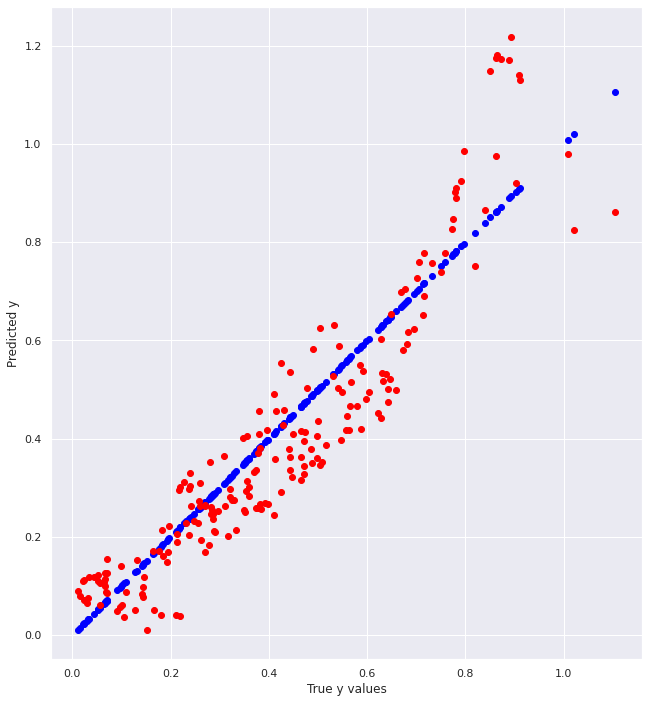

Test MSE OLS: 0.03149379849633013
Test MSE Ridge: 0.15455277648672278


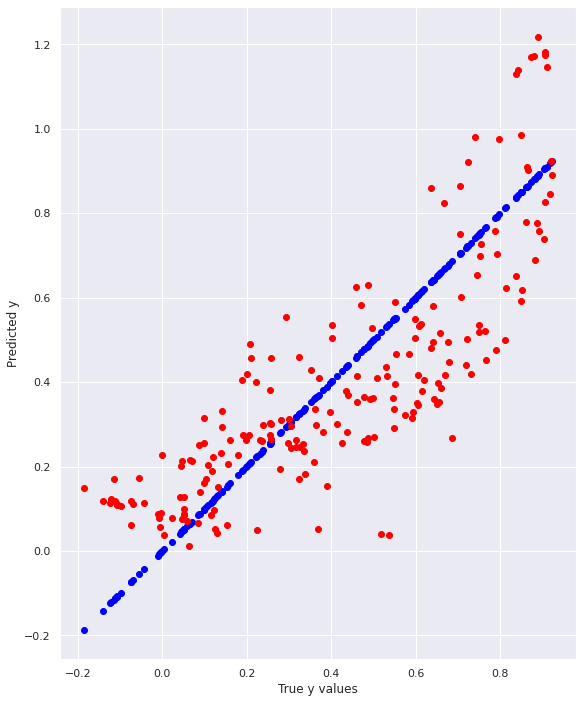

In [51]:
# a

##Make synthetic data
n = 1000  
np.random.seed(20)
x1 = np.random.rand(n)
x2 = np.random.rand(n)     
X = designMatrix(x1, x2, 4)
y = franke(x1, x2) 

##Train-validation-test samples. 
# We choose / play with hyper-parameters on the validation data and then test predictions on the test data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

X_train[:, 0] = 1
X_test[:, 0] = 1
X_val[:, 0] = 1



linreg = linregOwn(method='ols')
#print('Invert OLS:', linreg.fit(X_train, y_train))
beta = SGD(X_train, y_train, learning_rate=0.07)
#print('SGD OLS:', beta)


linreg = linregOwn(method='ridge')
#print('Invert Ridge:', linreg.fit(X_train, y_train, lambda_= 0.01))
beta = SGD(X_train, y_train, learning_rate=0.0004, method='ridge')
#print('SGD Ridge:', beta)


sgdreg = SGDRegressor(max_iter = 100, penalty=None, eta0=0.1)
sgdreg.fit(X_train[:, 1:],y_train.ravel())
#print('sklearn:', sgdreg.coef_)
#print('sklearn intercept:', sgdreg.intercept_)


def plot_MSE(method = 'ridge', scheme = None):
    eta = np.logspace(-5, -3, 10)
    lambda_ = np.logspace(-5, -1, 10)
    MSE_ols = []
    MSE_ridge = []
    
    if scheme == 'joint':
        
        if method == 'ridge':
            
            for lmbd in lambda_:
                
                for i in eta:  
                    
                    beta = SGD(X_train, y_train, learning_rate=i, lambda_ = lmbd, method = method)
                    mse_ols_test, mse_ridge_test = compute_test_mse(X_val, y_val, lambda_ = lmbd, beta = beta)
                    MSE_ridge.append(mse_ridge_test)
            
            fig = plt.figure()
            ax = fig.gca(projection='3d') ##get current axis
            lambda_ = np.ravel(lambda_)
            eta = np.ravel(eta)
            ax.zaxis.set_major_locator(LinearLocator(5))
            ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
            ax.xaxis.set_major_formatter(FormatStrFormatter('%.02f'))
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.03f'))
            ax.plot_trisurf(lambda_, eta, MSE_ridge, cmap='viridis', edgecolor='none')
            ax.set_xlabel(r'$\lambda$')
            ax.set_ylabel(r'$\eta$')
            ax.set_title(r'MSE Ridge')
            ax.view_init(30, 60)
            plt.show()
      
    if scheme == 'separate':
        
        if method == 'ols':
            
            eta = np.logspace(-5, 0, 10)  
            
            for i in eta:  
                
                beta = SGD(X_train, y_train, learning_rate=i, lambda_ = 0.01, method = method)
                mse_ols_test, mse_ridge_test = compute_test_mse(X_val, y_val, beta = beta)
                MSE_ols.append(mse_ols_test)
            
            print('The learning rate {} performs best for the OLS' .format(eta[MSE_ols.index(min(MSE_ols))]))
            print('Corresponding minimum MSE for OLS: {}'.format(min(MSE_ols)))
            plt.semilogx(eta, MSE_ols)
            plt.xlabel(r'Learning rate, $\eta$')
            plt.ylabel('MSE OLS')
            plt.title('Stochastic Gradient Descent')
            plt.show()
    if scheme == 'separate':
        
        if method == 'ridge':
            
            eta = np.logspace(-5, 0, 10)  
            
            for i in eta:  
                
                beta = SGD(X_train, y_train, learning_rate=i, lambda_ = 0.01, method = method)
                mse_ols_test, mse_ridge_test = compute_test_mse(X_val, y_val, beta = beta)
                MSE_ols.append(mse_ridge_test)
            
            print('The learning rate {} performs best for Ridge' .format(eta[MSE_ols.index(min(MSE_ols))]))
            print('Corresponding minimum MSE for Ridge: {}'.format(min(MSE_ols)))

            plt.plot(eta, MSE_ols)
            plt.xlabel(r'Learning rate, $\eta$')
            plt.ylabel('MSE Ridge')
            plt.title('Stochastic Gradient Descent')
            plt.show()
        

 
# plot_MSE(method='ridge', scheme = 'joint')

# plot_MSE(method='ols', scheme = 'separate')

# plot_MSE(method='ridge', scheme = 'separate')


####Predict OLS, Ridge on test data after tuning learning rate and lambda on validation data

def plot_scatter(y_true, method = 'ols'):
    if method == 'ols':
        beta = SGD(X_train, y_train, learning_rate=0.07, lambda_ = 0, method = method, n_epochs=300)
    if method == 'ridge':
        beta = SGD(X_train, y_train, learning_rate=0.0001, lambda_ = 0, method = method, n_epochs=300)
    y_pred = np.dot(X_test, beta)
    mse_ols_test, mse_ridge_test = compute_test_mse(X_test, y_true, beta = beta)
    print('Test MSE OLS: {}' .format(mse_ols_test))
    print('Test MSE Ridge: {}' .format(mse_ridge_test))
    a = plt.axes(aspect='equal')
    plt.scatter(y_pred, y_pred, color= 'blue')
    plt.scatter(y_pred, y_true, color = 'red')
    plt.xlabel('True y values')
    plt.ylabel('Predicted y')
    # if method == 'ols':
    #     plt.savefig(os.path.join(os.path.dirname(__file__), 'Plots', 'ols_reg_pred.png'), transparent=True, bbox_inches='tight')
    # if method == 'ridge':
    #     plt.savefig(os.path.join(os.path.dirname(__file__), 'Plots', 'ridge_reg_pred.png'), transparent=True, bbox_inches='tight')
    
    plt.show()

plot_scatter(y_test, method='ols')

plot_scatter(y_test, method='ridge')

#Part B

Learning rate  = 1e-05, Lambda = 1e-05, MSE = 0.028510952014546637 
Learning rate  = 1e-05, Lambda = 0.00031622776601683794, MSE = 0.028519509819163246 
Learning rate  = 1e-05, Lambda = 0.01, MSE = 0.028795619644490948 
Learning rate  = 1.778279410038923e-05, Lambda = 1e-05, MSE = 0.024749762194858835 
Learning rate  = 1.778279410038923e-05, Lambda = 0.00031622776601683794, MSE = 0.02475822193992542 
Learning rate  = 1.778279410038923e-05, Lambda = 0.01, MSE = 0.025044751275538405 
Learning rate  = 3.1622776601683795e-05, Lambda = 1e-05, MSE = 0.023478495237610107 
Learning rate  = 3.1622776601683795e-05, Lambda = 0.00031622776601683794, MSE = 0.02348212345652614 
Learning rate  = 3.1622776601683795e-05, Lambda = 0.01, MSE = 0.023659215159262156 
Learning rate  = 5.623413251903491e-05, Lambda = 1e-05, MSE = 0.02336120961847714 
Learning rate  = 5.623413251903491e-05, Lambda = 0.00031622776601683794, MSE = 0.023352856035978288 
Learning rate  = 5.623413251903491e-05, Lambda = 0.01, MSE 

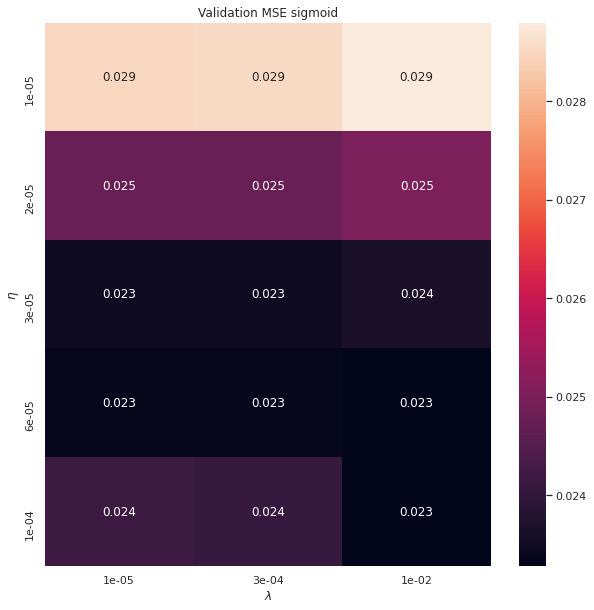

Learning rate  = 1e-06, Lambda = 0.01, MSE = 0.15232760238480528 
Learning rate  = 1e-06, Lambda = 0.03162277660168379, MSE = 0.15218078524084266 
Learning rate  = 1e-06, Lambda = 0.1, MSE = 0.15172489256664903 
Learning rate  = 1e-05, Lambda = 0.01, MSE = 0.09809239478596465 
Learning rate  = 1e-05, Lambda = 0.03162277660168379, MSE = 0.09707981240278425 
Learning rate  = 1e-05, Lambda = 0.1, MSE = 0.09434777098696721 
Learning rate  = 0.0001, Lambda = 0.01, MSE = 0.05256853164710248 
Learning rate  = 0.0001, Lambda = 0.03162277660168379, MSE = 0.04748372786730307 
Learning rate  = 0.0001, Lambda = 0.1, MSE = 0.06551564741512275 


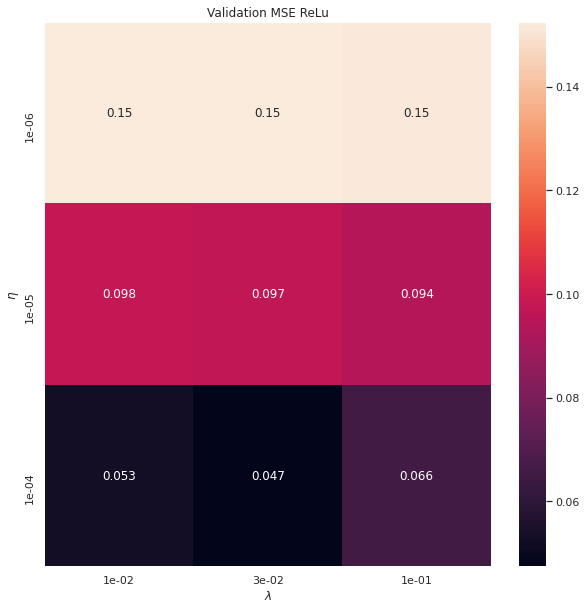

Learning rate  = 1e-05, Lambda = 0.01, MSE = 0.09817559656781459 
Learning rate  = 1e-05, Lambda = 0.03162277660168379, MSE = 0.09716308859485365 
Learning rate  = 1e-05, Lambda = 0.1, MSE = 0.09442696568309827 
Learning rate  = 1.883649089489802e-05, Lambda = 0.01, MSE = 0.0843300411863659 
Learning rate  = 1.883649089489802e-05, Lambda = 0.03162277660168379, MSE = 0.0834990230665652 
Learning rate  = 1.883649089489802e-05, Lambda = 0.1, MSE = 0.08169954460550742 
Learning rate  = 3.5481338923357534e-05, Lambda = 0.01, MSE = 0.06748800045552436 
Learning rate  = 3.5481338923357534e-05, Lambda = 0.03162277660168379, MSE = 0.06777878318724978 
Learning rate  = 3.5481338923357534e-05, Lambda = 0.1, MSE = 0.06991151797695115 
Learning rate  = 6.683439175686149e-05, Lambda = 0.01, MSE = 0.05175100556615824 
Learning rate  = 6.683439175686149e-05, Lambda = 0.03162277660168379, MSE = 0.05380596337165283 
Learning rate  = 6.683439175686149e-05, Lambda = 0.1, MSE = 0.06412917970764635 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:286: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:173: RuntimeWarning: invalid value encountered in less_equal
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: RuntimeWarning: invalid value encountered in less_equal


Learning rate  = 0.00012589254117941674, Lambda = 0.01, MSE = nan 
Learning rate  = 0.00012589254117941674, Lambda = 0.03162277660168379, MSE = 0.04516424557476063 
Learning rate  = 0.00012589254117941674, Lambda = 0.1, MSE = 0.06824173963465176 


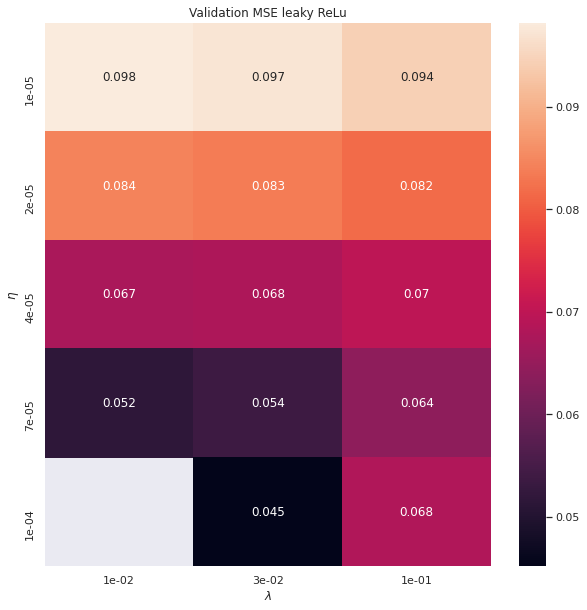

For alpha 0.01 and lambda 0.01 in activation function relu MSE is 0.08158619033010087 
For alpha 0.01 and lambda 0.1 in activation function relu MSE is 0.025572485734363562 
For alpha 0.1 and lambda 0.01 in activation function relu MSE is 0.08158619033010087 
For alpha 0.1 and lambda 0.1 in activation function relu MSE is 0.025572485734363562 
For alpha 0.01 and lambda 0.01 in activation function leaky_relu MSE is 0.08158457008502522 
For alpha 0.01 and lambda 0.1 in activation function leaky_relu MSE is 0.025593860226620715 
For alpha 0.1 and lambda 0.01 in activation function leaky_relu MSE is 0.08156995177809291 
For alpha 0.1 and lambda 0.1 in activation function leaky_relu MSE is 0.02584481634239263 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:154: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:281: RuntimeWarning: overflow encountered in multiply


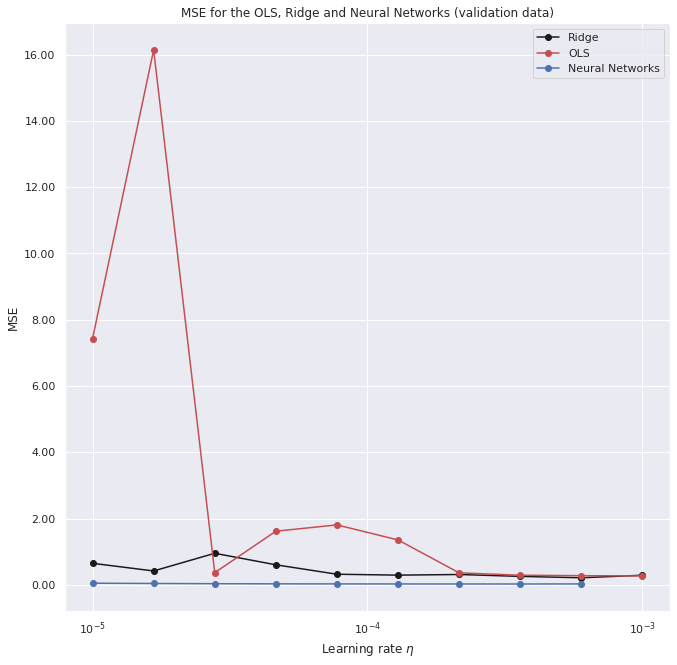

In [52]:
# b

##Make synthetic data
n = 1000  
np.random.seed(20)
x1 = np.random.rand(n)
x2 = np.random.rand(n)     
X = designMatrix(x1, x2, 4)
y = franke(x1, x2) 
X = X[:, 1:]

##Train-validation-test samples. We choose / play with hyper-parameters on the validation data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)




##playing with activation functions, learning rate and stochastic gradient descent decay

def plot_nn_mse(act):
        
    if act == 'sigmoid':
        learning_rate = np.logspace(-5, -4, 5)
        lambda_ = np.logspace(-5, -2, 3)
    if act == 'elu':
        learning_rate = np.logspace(-10, -8, 5)
        lambda_ = np.logspace(-5, -2, 3)
    if act == 'relu':
        learning_rate = np.logspace(-6, -4, 3)
        lambda_ = np.logspace(-2, -1, 3)
    if act == 'leaky_relu':
        learning_rate = np.logspace(-5, -3.9, 5)
        lambda_ = np.logspace(-2, -1, 3)    
    if act == 'tanh':
        learning_rate = np.logspace(-5, -3, 5)
        lambda_ = np.logspace(-5, -2, 3)
        
    n_categories = 1
    
    
    validation_MSE = np.zeros((len(learning_rate), len(lambda_)))
    
    DNN_numpy = np.zeros((len(learning_rate), len(lambda_)), dtype=object)

    # grid search
    for i, eta in enumerate(learning_rate):
        
        for j, lam in enumerate(lambda_):
            
            nn = NeuralNetwork()
            n_hidden = 50
            nn.add_layer(Layer(X_train.shape[1], n_hidden, act))
            nn.add_layer(Layer(n_hidden, n_hidden, 'sigmoid'))
            nn.add_layer(Layer(n_hidden, n_categories, None))
            
            nn.train(X_train, y_train, eta, 100, lmbd=lam, net_type='regression')
            
            DNN_numpy[i][j] = nn
            
            y_pred = nn.predict(X_val, net_type='regression')
                        
            print("Learning rate  = {}, Lambda = {}, MSE = {} " .format(eta, lam, nn.MSE((y_pred.flatten()), y_val) ))
    
    
    
    
    for i in range(len(learning_rate)):
        
        for j in range(len(lambda_)):  
                
            dnn = DNN_numpy[i][j]
    
            y_pred = dnn.predict(X_val, net_type='regression')
        
            #train_accuracy[i][j] = nn.accuracy((y_pred.flatten()), y_train)
            validation_MSE[i][j] = nn.MSE((y_pred.flatten()), y_val)
                    
    
 
    fig, ax = plt.subplots(figsize = (10, 10))
    xlabels = ['{:.0e}'.format(x) for x in lambda_]
    ylabels = ['{:.0e}'.format(y) for y in learning_rate]      
    sns.heatmap(validation_MSE, xticklabels = xlabels, yticklabels = ylabels, annot=True, ax=ax)
        
    if act == 'sigmoid':
        ax.set_title("Validation MSE sigmoid")
     
    if act == 'elu':
        
        ax.set_title("Validation MSE elu") 
                
    if act == 'relu':
        
        ax.set_title("Validation MSE ReLu")
                
    if act == 'leaky_relu':
        
        ax.set_title("Validation MSE leaky ReLu")
                        
    if act == 'tanh':
        
        ax.set_title("Validation MSE Tanh")
        
    ax.set_ylabel(r"$\eta$")
    ax.set_xlabel(r"$\lambda$")     
            
    #plt.savefig(os.path.join(os.path.dirname(__file__), 'Plots', 'MSE_reg_relu.png'), transparent=True, bbox_inches='tight')
    
    return plt.show()

plot_nn_mse(act = 'sigmoid')

plot_nn_mse(act = 'relu')

plot_nn_mse(act = 'leaky_relu')



### Play with hidden neurons and layers -18 neurons perform best with sigmoid activation

def play_with_neurons():
    n_hidden = [10, 15, 40, 50]
    MSE_hid = []

    for hidden in n_hidden:
        
        nn = NeuralNetwork()
        nn.add_layer(Layer(X_train.shape[1], hidden, 'sigmoid'))
        nn.add_layer(Layer(hidden, hidden, 'sigmoid'))
        #nn.add_layer(Layer(hidden, hidden, 'sigmoid'))
        nn.add_layer(Layer(hidden, 1, None))
        train = nn.train(X_train, y_train, 0.0001, 100, lmbd=0.01)
        y_pred = nn.predict(X_val, net_type='regression')
        MSE_hid.append(nn.MSE((y_pred.flatten()), y_val))
        print('For {} hidden neurons MSE is {} ' .format(hidden, nn.MSE((y_pred.flatten()), y_val)))
        

    plt.plot(n_hidden, MSE_hid, color = 'black', linestyle = 'dashed',linewidth = 1.5, marker = 'o', markersize=1)
    plt.xlabel('Hidden Neurons')
    plt.ylabel('Validation MSE (Sigmoid as an activation function)')
    #plt.savefig(os.path.join(os.path.dirname(__file__), 'Plots', 'n_hidden_mse_sigm.png'), transparent=True, bbox_inches='tight')
    return plt.show()


# play_with_neurons()


###Play with elu, relu, leaky_relu parameters
def play_with_activation():
    alpha = [0.01, 0.1]
    lambd = [0.01, 0.1]
    MSE_hid = []

    for act in ['relu', 'leaky_relu']:
        for a in alpha :
            for lambda_ in lambd:
                nn = NeuralNetwork()
                nn.add_layer(Layer(X_train.shape[1], 18 , act, alpha = a, lam = lambda_))
                nn.add_layer(Layer(18, 18, act, alpha = a, lam = lambda_))
                #nn.add_layer(Layer(hidden, hidden, 'sigmoid'))
                nn.add_layer(Layer(18, 1, None, alpha = a, lam = lambda_))
                train = nn.train(X_train, y_train, 0.001, 100, lmbd=0.001)
                y_pred = nn.predict(X_val, net_type='regression')
                MSE_hid.append(nn.MSE((y_pred.flatten()), y_val))
                print('For alpha {} and lambda {} in activation function {} MSE is {} ' .format(a, lambda_, act,  nn.MSE((y_pred.flatten()), y_val)))


play_with_activation()

def plot_MSE_ols_ridge_nn():
    MSE_ridge_val = []
    MSE_ols_val = []
    MSE_nn_val = []
    methods = ['ridge', 'ols', 'nn']
    for method in methods:
        
        if method == 'ridge':
            
            eta = np.logspace(-5, -3, 10) 
            
            for i in eta:            
                
                beta = SGD(X_train, y_train, learning_rate=i, lambda_ = 0.01, method = 'ridge')
                mse_ols_, mse_ridge_ = compute_test_mse(X_val, y_val, lambda_ = 0.01, beta = beta)
                MSE_ridge_val.append(mse_ridge_)
                
        if method == 'ols':
            
            eta = np.logspace(-5, -3, 10) 
            
            for i in eta:            
                
                beta = SGD(X_train, y_train, learning_rate=i, lambda_ = 0.01, method = 'ols')
                mse_ols_, mse_ridge_ = compute_test_mse(X_val, y_val, beta = beta)
                MSE_ols_val.append(mse_ols_)
        
        if method == 'nn':
            
            eta = np.logspace(-5, -3, 10) 
            
            for i in eta:
                
                nn = NeuralNetwork()
                nn.add_layer(Layer(X_train.shape[1], 18 , 'sigmoid', alpha = 0.1, lam = 0.1))
                nn.add_layer(Layer(18, 18, 'sigmoid', alpha = 0.1, lam = 0.1))
                #nn.add_layer(Layer(hidden, hidden, 'sigmoid'))
                nn.add_layer(Layer(18, 1, None, alpha = 0.1, lam = 0.1))
                train = nn.train(X_train, y_train, i, 100, lmbd=0.01)
                y_pred = nn.predict(X_val, net_type='regression')
                MSE_nn_val.append(nn.MSE((y_pred.flatten()), y_val))
        
    plot, ax = plt.subplots()
    plt.title('MSE for the OLS, Ridge and Neural Networks (validation data)')
    plt.semilogx(np.logspace(-5, -3, 10), MSE_ridge_val, 'k-o', label = 'Ridge')
    plt.semilogx(np.logspace(-5, -3, 10), MSE_ols_val, 'r-o', label = 'OLS')
    plt.semilogx(np.logspace(-5, -3, 10), MSE_nn_val, 'b-o', label = 'Neural Networks')
    plt.xlabel(r'Learning rate $\eta$')
    plt.ylabel('MSE')
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.legend()
    plt.subplots_adjust(left=0.2,bottom=0.2,right=0.9)
    #plt.savefig(os.path.join(os.path.dirname(__file__), 'Plots', 'mse_all.png'), transparent=True, bbox_inches='tight')
    return plt.show()

    
plot_MSE_ols_ridge_nn()


#Parts b and c with TensorFlow

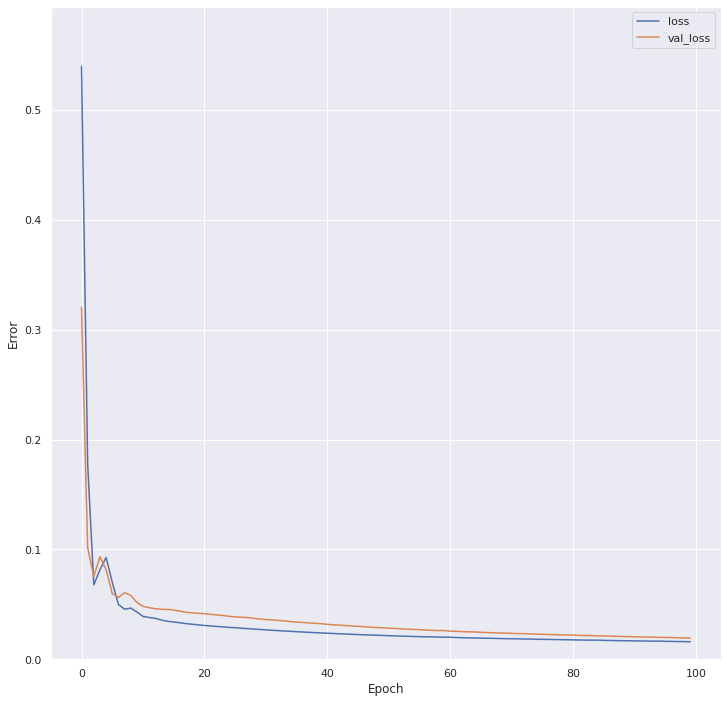

0.01779864728450775


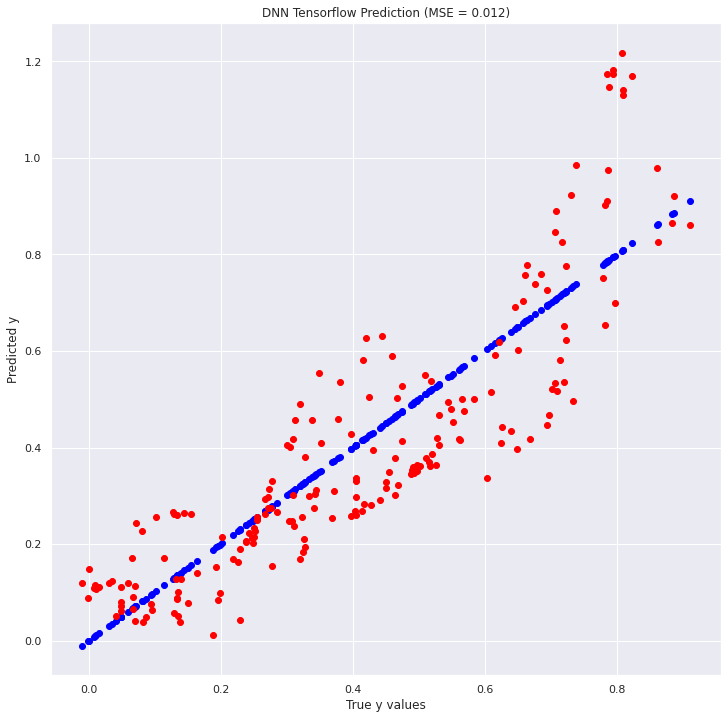

Test MSE: 0.02088275347740562


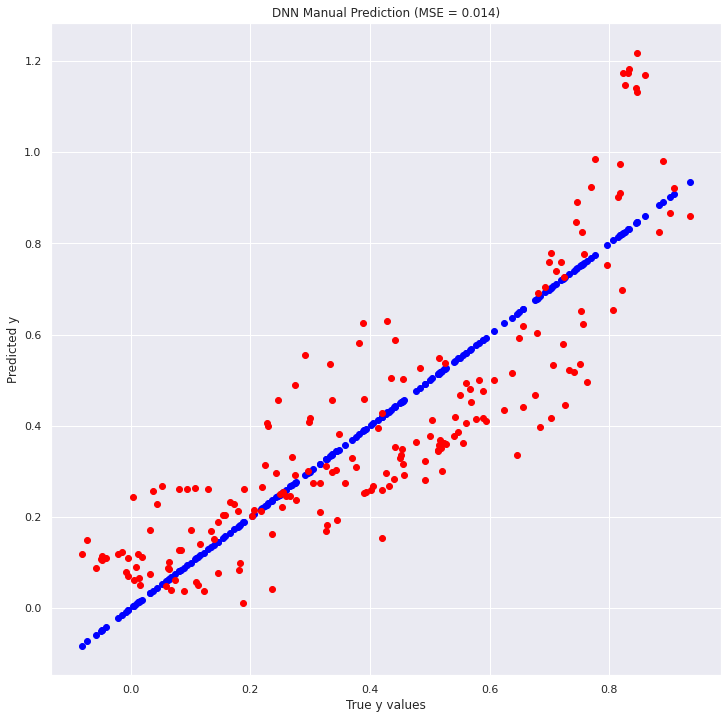

In [53]:
#b_c 

########## Regression ###########################

##Make synthetic data
n = 1000  
np.random.seed(20)
x1 = np.random.rand(n)
x2 = np.random.rand(n)     
X = designMatrix(x1, x2, 4)
y = franke(x1, x2) 
X = X[:, 1:]

##Train-validation-test samples. We choose / play with hyper-parameters on the validation data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2


scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)



## Define keras model
epochs = 100
batch_size = 100
n_neurons_layer1 = 50
n_neurons_layer2 = 50
n_categories = 10
eta_vals = np.logspace(-4, -1, 7)
lmbd_vals = np.logspace(-7, -5, 7)

def neural_network_keras(n_neurons_layer1, n_neurons_layer2, eta, lmbd):  ##Build the model
    model = Sequential()
    model.add(Dense(n_neurons_layer1, activation='sigmoid', kernel_regularizer=regularizers.l2(lmbd)))
    model.add(Dense(n_neurons_layer2, activation='sigmoid', kernel_regularizer=regularizers.l2(lmbd)))
    model.add(Dense(1, activation=None))
    
    sgd = optimizers.SGD(lr=eta)
    model.compile(loss='mean_squared_error', optimizer=sgd)  ##try adam also
    
    return model

DNN_keras = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)
  
def train_dnn():    ##fit for different learning rate and decay (lambda)  
    for i, eta in enumerate(eta_vals):
        for j, lmbd in enumerate(lmbd_vals):
            DNN = neural_network_keras(n_neurons_layer1, n_neurons_layer2, 
                                            eta=eta, lmbd=lmbd)
            DNN.fit(X_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, verbose=0) ##what is verbose?
            scores = DNN.evaluate(X_test, y_test, verbose=0)
            
            DNN_keras[i][j] = DNN
            
            print("Learning rate = ", eta)
            print("Lambda = ", lmbd)
            print("Test MSE: %.3f" % scores)
            print()  
  
#train_dnn()  
   
###For learning rate 0.1 and wno regularizing (i.e lambda = 0), we have the best test accuracy, thus use them here

def neural_network_no_l2(n_neurons_layer1, n_neurons_layer2, eta):
    model = Sequential()
    model.add(Dense(n_neurons_layer1, activation='sigmoid', kernel_regularizer=None))
    model.add(Dense(n_neurons_layer2, activation='sigmoid', kernel_regularizer=None))
    model.add(Dense(1, activation=None))
    
    sgd = optimizers.SGD(lr=eta)
    model.compile(loss='mean_squared_error', optimizer='adam')  ##adam performs much better than sgd
    
    return model

DNN = neural_network_no_l2(n_neurons_layer1, n_neurons_layer2, 
                                         eta=0.1)
dnn_keras = DNN.fit(X_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, verbose=0)

def plot_loss(history):
    plt.plot(dnn_keras.history['loss'], label='loss')
    plt.plot(dnn_keras.history['val_loss'], label='val_loss')
    plt.ylim([0, np.max(dnn_keras.history['loss'])*1.1])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    return plt.show()

plot_loss(dnn_keras)

print(DNN.evaluate(X_test, y_test, verbose=0))
y_pred = DNN.predict(X_test).flatten()


def plot_scatter(y_pred, y_true, backend = 'manual'):
    # a = plt.axes(aspect='equal')
    plt.scatter(y_pred, y_pred, color= 'blue')
    plt.scatter(y_pred, y_test, color = 'red')
    plt.xlabel('True y values')
    plt.ylabel('Predicted y')
    if backend == 'tfl':
        plt.title('DNN Tensorflow Prediction (MSE = 0.012)')
        plt.show()
    if backend == 'manual':
        plt.title('DNN Manual Prediction (MSE = 0.014)')
        plt.show()
    
plot_scatter(y_pred, y_test, backend='tfl') ##Tensorflow predictions
     

def mymodel():
    nn = NeuralNetwork()
    nn.add_layer(Layer(X_train.shape[1], 50 , 'sigmoid', alpha = 0.01, lam = 0.1))
    nn.add_layer(Layer(50, 50, 'sigmoid', alpha = 0.01, lam = 0.1))
    #nn.add_layer(Layer(18, 18, 'sigmoid'))
    nn.add_layer(Layer(50, 1, None, alpha = 0.01, lam = 0.1))
    train = nn.train(X_train, y_train, 0.0001, 100, lmbd=0.01)
    y_pred = nn.predict(X_test, net_type='regression')
    print('Test MSE: {}' .format(nn.MSE(y_pred.flatten(), y_test)))
    return y_pred

y_pred = mymodel()

plot_scatter(y_pred, y_test, backend='manual') ### my own nn predictions

#Part d

inputs = (n_inputs, pixel_width, pixel_height) = (1797, 8, 8)
labels = (n_inputs) = (1797,)
X = (n_inputs, n_features) = (1797, 64)
Number of training images: 1077
Number of test images: 360
Learning rate  = 1e-05, Lambda = 1e-05, Accuracy = 0.2638888888888889 
Learning rate  = 1e-05, Lambda = 0.001, Accuracy = 0.2638888888888889 
Learning rate  = 1e-05, Lambda = 0.1, Accuracy = 0.2638888888888889 
Learning rate  = 0.0001, Lambda = 1e-05, Accuracy = 0.6444444444444445 
Learning rate  = 0.0001, Lambda = 0.001, Accuracy = 0.6444444444444445 
Learning rate  = 0.0001, Lambda = 0.1, Accuracy = 0.675 
Learning rate  = 0.001, Lambda = 1e-05, Accuracy = 0.9138888888888889 
Learning rate  = 0.001, Lambda = 0.001, Accuracy = 0.9166666666666666 
Learning rate  = 0.001, Lambda = 0.1, Accuracy = 0.24444444444444444 
Learning rate  = 0.01, Lambda = 1e-05, Accuracy = 0.7916666666666666 
Learning rate  = 0.01, Lambda = 0.001, Accuracy = 0.7111111111111111 
Learning rate  = 0.01, Lambda = 0.1, Accuracy

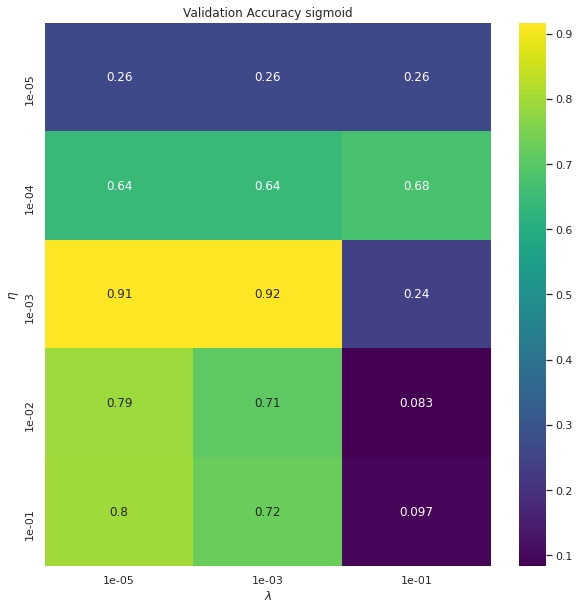

Learning rate  = 1e-05, Lambda = 1e-05, Accuracy = 0.10555555555555556 
Learning rate  = 1e-05, Lambda = 0.001, Accuracy = 0.10555555555555556 
Learning rate  = 1e-05, Lambda = 0.1, Accuracy = 0.1111111111111111 
Learning rate  = 0.0001, Lambda = 1e-05, Accuracy = 0.5166666666666667 
Learning rate  = 0.0001, Lambda = 0.001, Accuracy = 0.5166666666666667 
Learning rate  = 0.0001, Lambda = 0.1, Accuracy = 0.525 
Learning rate  = 0.001, Lambda = 1e-05, Accuracy = 0.825 
Learning rate  = 0.001, Lambda = 0.001, Accuracy = 0.825 
Learning rate  = 0.001, Lambda = 0.1, Accuracy = 0.22777777777777777 
Learning rate  = 0.01, Lambda = 1e-05, Accuracy = 0.8027777777777778 
Learning rate  = 0.01, Lambda = 0.001, Accuracy = 0.8166666666666667 
Learning rate  = 0.01, Lambda = 0.1, Accuracy = 0.008333333333333333 
Learning rate  = 0.1, Lambda = 1e-05, Accuracy = 0.3388888888888889 
Learning rate  = 0.1, Lambda = 0.001, Accuracy = 0.10555555555555556 
Learning rate  = 0.1, Lambda = 0.1, Accuracy = 0.17

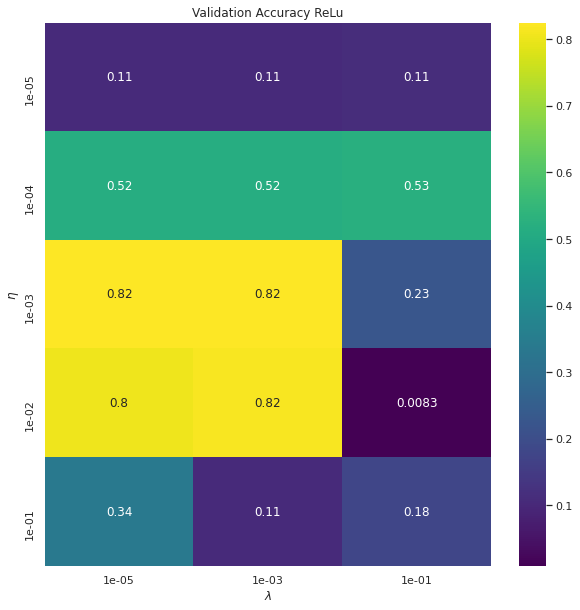

Learning rate  = 1e-05, Lambda = 1e-05, Accuracy = 0.28055555555555556 
Learning rate  = 1e-05, Lambda = 0.001, Accuracy = 0.2833333333333333 
Learning rate  = 1e-05, Lambda = 0.1, Accuracy = 0.28888888888888886 
Learning rate  = 0.0001, Lambda = 1e-05, Accuracy = 0.65 
Learning rate  = 0.0001, Lambda = 0.001, Accuracy = 0.6527777777777778 
Learning rate  = 0.0001, Lambda = 0.1, Accuracy = 0.8916666666666667 
Learning rate  = 0.001, Lambda = 1e-05, Accuracy = 0.7722222222222223 
Learning rate  = 0.001, Lambda = 0.001, Accuracy = 0.7611111111111111 
Learning rate  = 0.001, Lambda = 0.1, Accuracy = 0.125 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:189: RuntimeWarning: invalid value encountered in true_divide


Learning rate  = 0.01, Lambda = 1e-05, Accuracy = 0.09166666666666666 
Learning rate  = 0.01, Lambda = 0.001, Accuracy = 0.09166666666666666 
Learning rate  = 0.01, Lambda = 0.1, Accuracy = 0.11666666666666667 
Learning rate  = 0.1, Lambda = 1e-05, Accuracy = 0.09166666666666666 
Learning rate  = 0.1, Lambda = 0.001, Accuracy = 0.09166666666666666 
Learning rate  = 0.1, Lambda = 0.1, Accuracy = 0.09166666666666666 


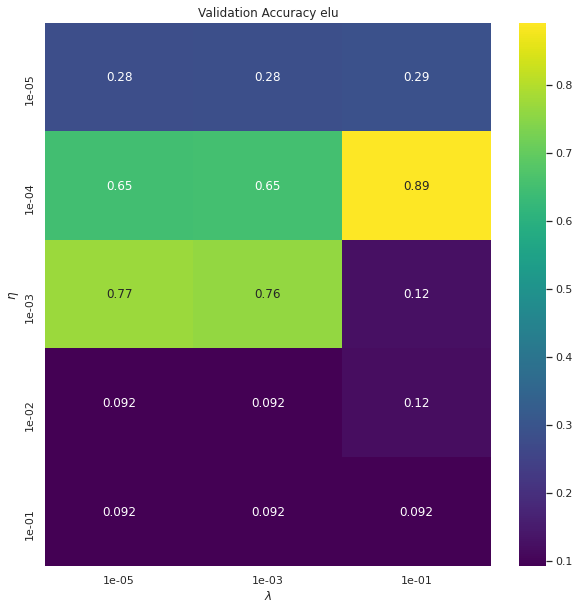

Learning rate  = 1e-05, Lambda = 1e-05, Accuracy = 0.10555555555555556 
Learning rate  = 1e-05, Lambda = 0.001, Accuracy = 0.10555555555555556 
Learning rate  = 1e-05, Lambda = 0.1, Accuracy = 0.1111111111111111 
Learning rate  = 0.0001, Lambda = 1e-05, Accuracy = 0.5194444444444445 
Learning rate  = 0.0001, Lambda = 0.001, Accuracy = 0.5194444444444445 
Learning rate  = 0.0001, Lambda = 0.1, Accuracy = 0.525 
Learning rate  = 0.001, Lambda = 1e-05, Accuracy = 0.8194444444444444 
Learning rate  = 0.001, Lambda = 0.001, Accuracy = 0.825 
Learning rate  = 0.001, Lambda = 0.1, Accuracy = 0.22777777777777777 
Learning rate  = 0.01, Lambda = 1e-05, Accuracy = 0.7944444444444444 
Learning rate  = 0.01, Lambda = 0.001, Accuracy = 0.8138888888888889 
Learning rate  = 0.01, Lambda = 0.1, Accuracy = 0.008333333333333333 
Learning rate  = 0.1, Lambda = 1e-05, Accuracy = 0.35833333333333334 
Learning rate  = 0.1, Lambda = 0.001, Accuracy = 0.09444444444444444 
Learning rate  = 0.1, Lambda = 0.1, A

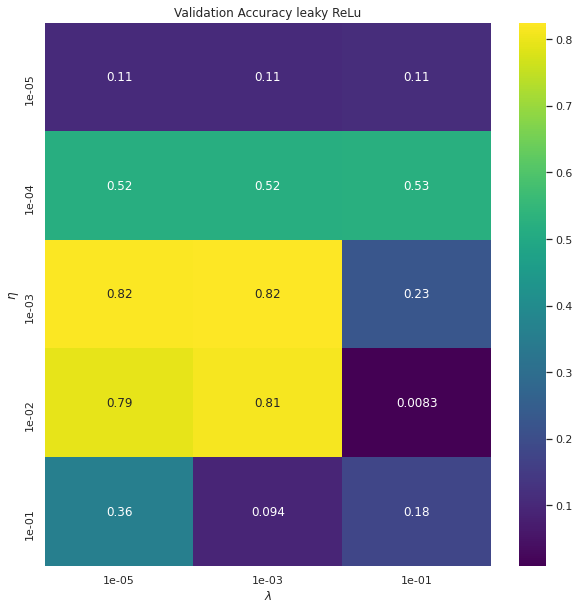

Learning rate  = 1e-05, Lambda = 1e-05, Accuracy = 0.1111111111111111 
Learning rate  = 1e-05, Lambda = 0.001, Accuracy = 0.1111111111111111 
Learning rate  = 1e-05, Lambda = 0.1, Accuracy = 0.11388888888888889 
Learning rate  = 0.0001, Lambda = 1e-05, Accuracy = 0.5333333333333333 
Learning rate  = 0.0001, Lambda = 0.001, Accuracy = 0.5361111111111111 
Learning rate  = 0.0001, Lambda = 0.1, Accuracy = 0.85 
Learning rate  = 0.001, Lambda = 1e-05, Accuracy = 0.8472222222222222 
Learning rate  = 0.001, Lambda = 0.001, Accuracy = 0.8555555555555555 
Learning rate  = 0.001, Lambda = 0.1, Accuracy = 0.9138888888888889 
Learning rate  = 0.01, Lambda = 1e-05, Accuracy = 0.8694444444444445 
Learning rate  = 0.01, Lambda = 0.001, Accuracy = 0.8888888888888888 
Learning rate  = 0.01, Lambda = 0.1, Accuracy = 0.8 
Learning rate  = 0.1, Lambda = 1e-05, Accuracy = 0.6027777777777777 
Learning rate  = 0.1, Lambda = 0.001, Accuracy = 0.3 
Learning rate  = 0.1, Lambda = 0.1, Accuracy = 0.638888888888

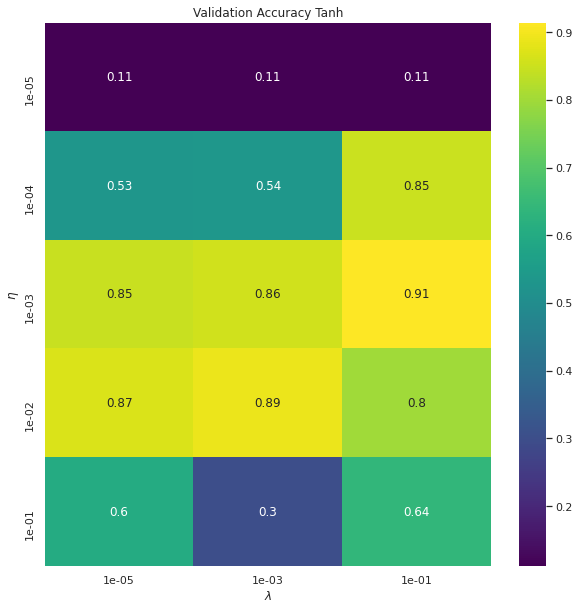

For 10 hidden neurons accuracy is 0.7416666666666667 
For 20 hidden neurons accuracy is 0.8055555555555556 
For 30 hidden neurons accuracy is 0.8833333333333333 
For 40 hidden neurons accuracy is 0.9361111111111111 
For 50 hidden neurons accuracy is 0.9166666666666666 
For 100 hidden neurons accuracy is 0.9361111111111111 


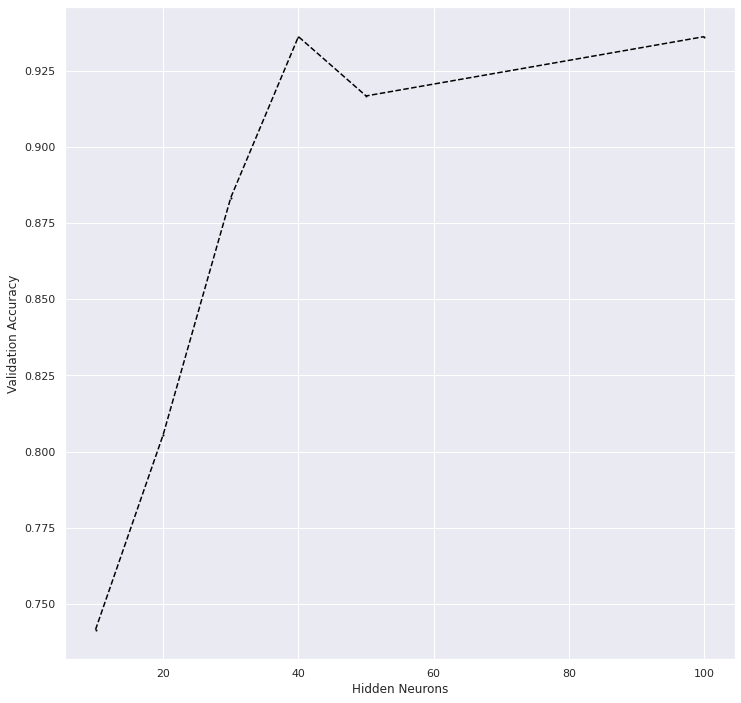

0.9444444444444444


In [54]:
# d

###Data pre-processing########

# ensure the same random numbers appear every time
np.random.seed(20)

# display images in notebook
plt.rcParams['figure.figsize'] = (12,12)


# download MNIST dataset
digits = datasets.load_digits()

# define inputs and labels
inputs = digits.images
labels = digits.target

print("inputs = (n_inputs, pixel_width, pixel_height) = " + str(inputs.shape))
print("labels = (n_inputs) = " + str(labels.shape))


# flatten the image
# the value -1 means dimension is inferred from the remaining dimensions: 8x8 = 64
n_inputs = len(inputs)
inputs = inputs.reshape(n_inputs, -1)
print("X = (n_inputs, n_features) = " + str(inputs.shape))


# choose some random images to display
indices = np.arange(n_inputs)
random_indices = np.random.choice(indices, size=5)

def plot_digits():
    for i, image in enumerate(digits.images[random_indices]):
        plt.subplot(1, 5, i+1)
        plt.axis('off')
        plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
        plt.title("Label: %d" % digits.target[random_indices[i]])
        plt.show()


###split into train - validation -test data. Choose hyper-parameters on the validation data

X_train, X_test, y_train, y_test = train_test_split(inputs, labels, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

###scale the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)


print("Number of training images: " + str(len(X_train)))
print("Number of test images: " + str(len(X_test)))

def to_categorical_numpy(integer_vector):
    n_inputs = len(integer_vector)
    n_categories = np.max(integer_vector) + 1
    onehot_vector = np.zeros((n_inputs, n_categories))
    onehot_vector[range(n_inputs), integer_vector] = 1
    
    return onehot_vector

y_train_onehot, y_test_onehot, y_val_onehot = to_categorical_numpy(y_train), to_categorical_numpy(y_test), to_categorical_numpy(y_val)


def plot_nn_accuracy(act):
        
    if act == 'sigmoid':
        learning_rate = np.logspace(-5, -1, 5)
        lambda_ = np.logspace(-5, -1, 3)
    if act == 'elu':
        learning_rate = np.logspace(-5, -1, 5)
        lambda_ = np.logspace(-5, -1, 3)
    if act == 'relu':
        learning_rate = np.logspace(-5, -1, 5)
        lambda_ = np.logspace(-5, -1, 3)
    if act == 'leaky_relu':
        learning_rate = np.logspace(-5, -1, 5)
        lambda_ = np.logspace(-5, -1, 3)
    if act == 'tanh':
        learning_rate = np.logspace(-5, -1, 5)
        lambda_ = np.logspace(-5, -1, 3)
        

    n_categories = np.max(labels) + 1
    
    
    train_accuracy = np.zeros((len(learning_rate), len(lambda_)))
    validation_accuracy = np.zeros((len(learning_rate), len(lambda_)))
    
    DNN_numpy = np.zeros((len(learning_rate), len(lambda_)), dtype=object)

    # grid search
    for i, eta in enumerate(learning_rate):
        
        for j, lam in enumerate(lambda_):
            
            nn = NeuralNetwork()
            n_hidden = 50
            nn.add_layer(Layer(X_train.shape[1], n_hidden, act))
            #nn.add_layer(Layer(n_hidden, n_hidden, 'sigmoid'))
            nn.add_layer(Layer(n_hidden, n_categories, 'softmax'))
            
            nn.train(X_train, y_train_onehot, eta, 100, lmbd=lam, net_type='classification')
            
            DNN_numpy[i][j] = nn
            
            y_pred = nn.predict(X_val, net_type='classification')
                        
            print("Learning rate  = {}, Lambda = {}, Accuracy = {} " .format(eta, lam, nn.accuracy((y_pred.flatten()), y_val) ))
    
    
    
    
    for i in range(len(learning_rate)):
        
        for j in range(len(lambda_)):  
                
            dnn = DNN_numpy[i][j]
    
            y_pred = dnn.predict(X_val, net_type='classification')
        
            #train_accuracy[i][j] = nn.accuracy((y_pred.flatten()), y_train)
            validation_accuracy[i][j] = nn.accuracy((y_pred.flatten()), y_val)
                    
    
 
    fig, ax = plt.subplots(figsize = (10, 10))
    xlabels = ['{:.0e}'.format(x) for x in lambda_]
    ylabels = ['{:.0e}'.format(y) for y in learning_rate]    
    sns.heatmap(validation_accuracy, xticklabels = xlabels, yticklabels = ylabels, annot=True, ax=ax, cmap='viridis')
        
    if act == 'sigmoid':
        ax.set_title("Validation Accuracy sigmoid")
        
    if act == 'elu':
        
        ax.set_title("Validation Accuracy elu")
              
    if act == 'relu':
        
        ax.set_title("Validation Accuracy ReLu")
                 
    if act == 'leaky_relu':
        
        ax.set_title("Validation Accuracy leaky ReLu")

    if act == 'tanh':
        
        ax.set_title("Validation Accuracy Tanh")
        
    ax.set_ylabel(r"$\eta$")
    ax.set_xlabel(r"$\lambda$")     
            
    #plt.savefig(os.path.join(os.path.dirname(__file__), 'Plots', 'accuracy_valid_tanh.png'), transparent=True, bbox_inches='tight')
    
    return plt.show()


plot_nn_accuracy('sigmoid')
plot_nn_accuracy('relu') 
plot_nn_accuracy('elu')  
plot_nn_accuracy('leaky_relu')
plot_nn_accuracy('tanh')


##### Play with different hidden nodes

def accuracy_hidden():
    n_hidden = [10, 20, 30, 40, 50, 100]
    Accuracy_hid = []
    n_categories = np.max(labels) + 1

    for hidden in n_hidden:
        
        nn = NeuralNetwork()
        nn.add_layer(Layer(X_train.shape[1], hidden, 'sigmoid'))
        #nn.add_layer(Layer(n_hidden, n_hidden, 'sigmoid'))
        nn.add_layer(Layer(hidden, n_categories, 'softmax'))
        train = nn.train(X_train, y_train_onehot, 0.001, 100, lmbd=0.001, net_type='classification')
        y_pred = nn.predict(X_val, net_type='classification')
        Accuracy_hid.append(nn.accuracy((y_pred.flatten()), y_val))
        print('For {} hidden neurons accuracy is {} ' .format(hidden, nn.accuracy((y_pred.flatten()), y_val)))
        

    plt.plot(n_hidden, Accuracy_hid, color = 'black', linestyle = 'dashed',linewidth = 1.5, marker = 'o', markersize=1)
    plt.xlabel('Hidden Neurons')
    plt.ylabel('Validation Accuracy')
    return plt.show()

accuracy_hidden()  ##40 hidden layers is most optimal



###Test accuracy
nn = NeuralNetwork()
nn.add_layer(Layer(X_train.shape[1], 40, 'sigmoid'))
#nn.add_layer(Layer(n_hidden, n_hidden, 'sigmoid'))
nn.add_layer(Layer(40, 10, 'softmax'))
train = nn.train(X_train, y_train_onehot, 0.001, 300, lmbd=0.001, net_type='classification')
y_pred = nn.predict(X_test, net_type='classification')
print(nn.accuracy((y_pred.flatten()), y_test))

#Part e

inputs = (n_inputs, pixel_width, pixel_height) = (1797, 8, 8)
labels = (n_inputs) = (1797,)
X = (n_inputs, n_features) = (1797, 64)
Number of training images: 1077
Number of test images: 360
Learning rate  = 0.001, Lambda = 0.001, Accuracy = 0.8916666666666667 
Learning rate  = 0.001, Lambda = 0.01, Accuracy = 0.9333333333333333 
Learning rate  = 0.001, Lambda = 0.1, Accuracy = 0.9583333333333334 
Learning rate  = 0.001, Lambda = 1.0, Accuracy = 0.9611111111111111 
Learning rate  = 0.01, Lambda = 0.001, Accuracy = 0.8916666666666667 
Learning rate  = 0.01, Lambda = 0.01, Accuracy = 0.9333333333333333 
Learning rate  = 0.01, Lambda = 0.1, Accuracy = 0.9583333333333334 
Learning rate  = 0.01, Lambda = 1.0, Accuracy = 0.9611111111111111 
Learning rate  = 0.1, Lambda = 0.001, Accuracy = 0.8888888888888888 
Learning rate  = 0.1, Lambda = 0.01, Accuracy = 0.925 
Learning rate  = 0.1, Lambda = 0.1, Accuracy = 0.9333333333333333 
Learning rate  = 0.1, Lambda = 1.0, Accuracy = 0.933333333333333

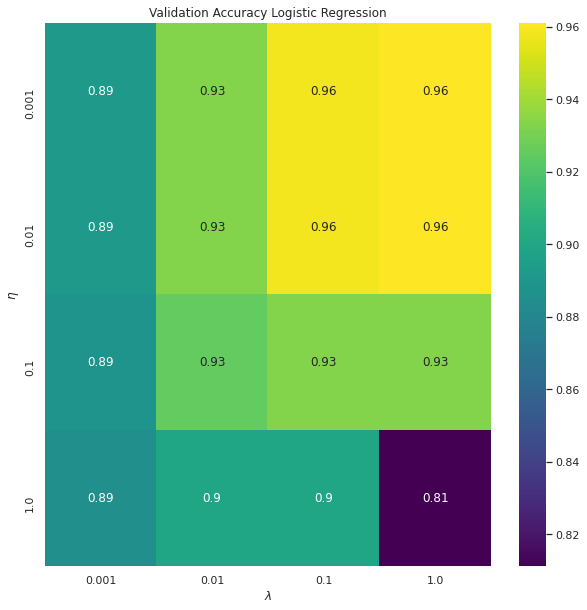

scikit learn: 0.9638888888888889
Manual accuracy: 0.95


In [55]:
# e

### Multiclass Logistic Regression ###

#####Load the data #######
###Data pre-processing########

# ensure the same random numbers appear every time
np.random.seed(20)

# display images in notebook
plt.rcParams['figure.figsize'] = (12,12)


# download MNIST dataset
digits = datasets.load_digits()

# define inputs and labels
inputs = digits.images
labels = digits.target

print("inputs = (n_inputs, pixel_width, pixel_height) = " + str(inputs.shape))
print("labels = (n_inputs) = " + str(labels.shape))


# flatten the image
# the value -1 means dimension is inferred from the remaining dimensions: 8x8 = 64
n_inputs = len(inputs)
inputs = inputs.reshape(n_inputs, -1)
print("X = (n_inputs, n_features) = " + str(inputs.shape))


# choose some random images to display
indices = np.arange(n_inputs)
random_indices = np.random.choice(indices, size=5)

def plot_digits():
    for i, image in enumerate(digits.images[random_indices]):
        plt.subplot(1, 5, i+1)
        plt.axis('off')
        plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
        plt.title("Label: %d" % digits.target[random_indices[i]])
        plt.show()
        
        
###split into train - validation -test data. Choose hyper-parameters on the validation data

X_train, X_test, y_train, y_test = train_test_split(inputs, labels, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

###scale the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

def append_intercept(X):
    xb = np.ones((X.shape[0], 1))
    return np.c_[xb, X]

X_train = append_intercept(X_train)
X_test = append_intercept(X_test)
X_val = append_intercept(X_val)


print("Number of training images: " + str(len(X_train)))
print("Number of test images: " + str(len(X_test)))


def to_categorical_numpy(integer_vector):
    n_inputs = len(integer_vector)
    n_categories = np.max(integer_vector) + 1
    onehot_vector = np.zeros((n_inputs, n_categories))
    onehot_vector[range(n_inputs), integer_vector] = 1
    
    return onehot_vector

y_train_onehot, y_test_onehot, y_val_onehot = to_categorical_numpy(y_train), to_categorical_numpy(y_test), to_categorical_numpy(y_val)

learningRate = np.logspace(-3, 0, 4)
lmbd = np.logspace(-3, 0, 4) 


###Checking validation set accuracy for different values of learning rate and regularization

def plot_logistic_accuracy():
    learning_rate = np.logspace(-3, 0, 4)
    lambda_ = np.logspace(-3, 0, 4)
    n_categories = np.max(labels) + 1
    
    validation_accuracy = np.zeros((len(learning_rate), len(lambda_)))
    
    logistic_numpy = np.zeros((len(learning_rate), len(lambda_)), dtype=object)

    # grid search
    for i, eta in enumerate(learning_rate):
        
        for j, lam in enumerate(lambda_):
            
            logreg = multiclassLogistic(X_train, y_train, y_train_onehot, learning_rate=eta, lambda_ = lam)
            beta = logreg.sgd(X_train, y_train, y_train_onehot, 1000, lambda_ = eta, learning_rate= lam)
            
            validation_accuracy[i][j] = logreg.accuracy(X_val, y_val, beta)
            
                                        
            print("Learning rate  = {}, Lambda = {}, Accuracy = {} " .format(eta, lam, logreg.accuracy(X_val, y_val, beta)))

         
    fig, ax = plt.subplots(figsize = (10, 10))
    #xlabels = ['{:3.1f}'.format(x) for x in lambda_]
    #ylabels = ['{:3.1f}'.format(y) for y in learning_rate]       
    sns.heatmap(validation_accuracy, xticklabels = lambda_, yticklabels = learning_rate, annot=True, ax=ax, cmap="viridis")
        
    ax.set_title("Validation Accuracy Logistic Regression")
    ax.set_ylabel(r"$\eta$")
    ax.set_xlabel(r"$\lambda$")
    
    #plt.savefig(os.path.join(os.path.dirname(__file__), 'Plots', 'logistic_accuracy.png'), transparent=True, bbox_inches='tight')

    return plt.show()
         

plot_logistic_accuracy()


    
#### Compare with scikit learn ####
        
lr = LogisticRegression(solver='lbfgs',
                                multi_class='multinomial',
                                penalty='l2',
                                max_iter=100,
                                random_state=42,
                                C=1e5)


##Validation accuracy scikit learn - same test data accuracy as my own

lr.fit(X_train, y_train)
pred = lr.predict(X_test)
print('scikit learn: {}'.format(sum(pred == y_test)/(float(len(y_test))))) 


logreg = multiclassLogistic(X_train, y_train, y_train_onehot, learning_rate=0.01, lambda_ = 0.01)
beta = logreg.sgd(X_train, y_train, y_train_onehot, 1000, learning_rate=0.01, lambda_ = 0.01)
print('Manual accuracy: {}' .format(logreg.accuracy(X_test, y_test, beta)))
